# Modeling and Simulations Project 1

Studio 1

Jinfay Yuan & Jack Mao

In [27]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

from pandas import read_html

In [50]:
tables = read_html('https://en.wikipedia.org/wiki/United_States_immigration_statistics',
header=0,
decimal = '.',
index_col=0)
table2 = tables[1]
table2.index.get_loc('China')
#Reads data from wikipedia

56

In [29]:
China = table2.loc['China']
China = China.reindex(index=China.index[::-1]) #Reorganizes the index of values (reverses it)

index = China.index.astype(float) #Sets the data type as a float
values = China.values.astype(float)

china = TimeSeries(data = values, index = index) #Creates a time series called China

,values
1850.0,758.0
1860.0,35565.0
1870.0,63042.0
1880.0,104468.0
1890.0,106688.0
1900.0,81534.0
1910.0,56756.0
1920.0,43560.0
1950.0,46129.0
1960.0,99735.0


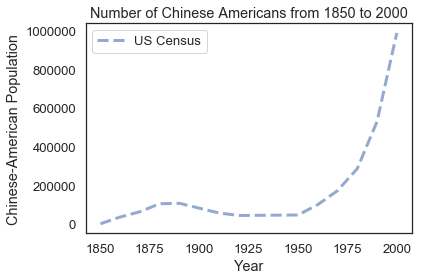

In [30]:
plot(china, '--',label='US Census')
decorate(xlabel='Year', 
            ylabel='Chinese-American Population',
            title="Number of Chinese Americans from 1850 to 2000")

## What would the Chinese-American population look like in the year 2000 if the Chinese Exclusion Act of 1882 and the Geary Act had not existed?
As the previous figure shows, the Chinese-American population decreased during 1880-1940. This phenomenon is the effect of the Chinese Exclusion Act of 1882 and the Geary Act, which banned the immigration of Chinese laborers into the United States. With no influx of immigrants, the population of Chinese-Americans began to fade with time.

If these policies were never approved, what would the Chinese-American population look like in 2000?

To dive deeper into this question, we will consider three variables: birth rate, death rate, and the immigration rate. Because the effects of the Chinese Exclusion Act and the Geary Act is the sole focus of this project, the birth/death rate will simply be held constant and the immigration rate will be more closely examined. In order to do so, the immigration rate is modeled based on the change in population prior to the passing of the two policies. Using this model, we can then extrapolate immigration rates for the years in which the policies were passed and create a population model that explores an answer to our question.


We used data from the U.S. Dept. of Homeland Security to plot the the number of Chinese immigrants that arrived in the United States every decade from 1850-2000.

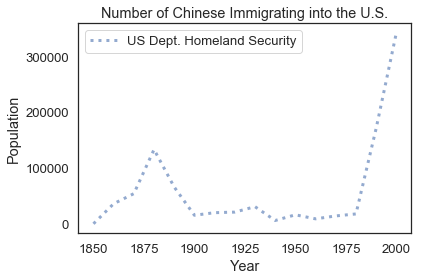

In [31]:
Year = linrange(1850, 2000, 10,endpoint=True)
pop = [32, 35933,54028, 133139, 65797, 15268, 19884, 20916, 30648, 5874, 16072, 8836, 14060, 17627, 170897,342058] 
immigrant_influx = TimeSeries(pop, Year)

plot(immigrant_influx, ':', label='US Dept. Homeland Security')
decorate(xlabel='Year', 
            ylabel='Population',
            title="Number of Chinese Immigrating into the U.S.")

We then created a plot_results function that allowed us to graph a model over the previous plot.

In [32]:
def plot_results(immigrant_influx,timeseries,title, label):
    """Plot the estimates and the model.
    
    immigrant_influx = actual data of how many chinese-americans immigrated
    timeseries: TimeSeries of simulation results
    title: string
    """
    plot(immigrant_influx, ':', label = label)
    plot(timeseries, color='gray', label='model')
    
    decorate(xlabel='Year', 
             ylabel='Population',
             title=title)

In order to figure out which type of model would work best for extrapolating data, we tested how well constant, proportional, and quadratic models fit. We started with a constant model and calculated the decadal growth of the population. 

In [33]:
t_0 = Year[0]
t_1880 = Year[3]
elasped_time = t_1880 - t_0
p_0 = pop[0]
p_end = pop[3]
total_growth = p_end - p_0

decadal_growth = total_growth/(elasped_time/10)

44369.0

In [34]:
results = TimeSeries()
results[t_0] = p_0
for t in linrange(t_0,t_1880,10):
    results[t+10] = results[t] + decadal_growth


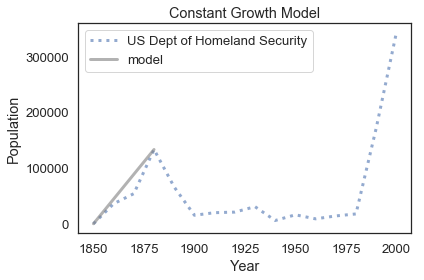

In [35]:
plot_results(immigrant_influx,results,'Constant Growth Model', 'US Dept of Homeland Security')

Next, we tested a proportional model. To start, we store the parameters of the model (initial year, end year, intitial population, some constant alpha) in a `System` object.

In [36]:
system = System(t_0=Year[0], 
                t_1880=Year[3],
                p_0=pop[0],
                alpha=15)

,values
t_0,1850.0
t_1880,1880.0
p_0,32.0
alpha,15.0


The `run_simulation` function is taken from class and is used to simulate the system given an update function.

In [37]:
def run_simulation(system, update_func):
    """
    Simulate the system using any update function
    system: takes a initial System
    update_func: function that computes the population next decade
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_0] = system.p_0
    
    for t in linrange(t_0, t_1880, 10):
        results[t+10] = update_func(results[t], t, system)
        
    return results

We then create an update function that assumes the proportional growth of Chinese immigrants coming to the United States.

In [38]:
def update_func_prop(pop, t, system):
    """Compute the population next decade with a proportional model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next decade
    """
    net_growth = system.alpha * pop
  
    return pop + net_growth

1850        32.0
1860     44401.0
1870     88770.0
1880    133139.0
dtype: float64


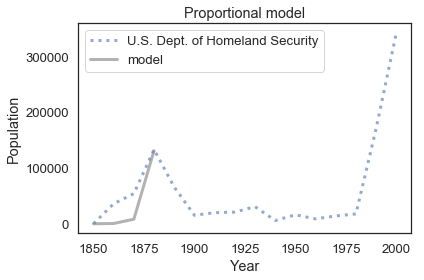

In [39]:
prop_results = run_simulation(system, update_func_prop)
plot_results(immigrant_influx,prop_results,'Proportional model', 'U.S. Dept. of Homeland Security')
print(results)

Finally, we take a look at the quadratic model. A new `System` object is created. This time, we add a second parameter, beta, to model the population growth.

In [40]:
system_quad = System(t_0=Year[0], 
                t_end=Year[3],
                p_0=pop[0],
                alpha=15,
                beta=.000575)



,values
t_0,1850.000000
t_end,1880.000000
p_0,32.000000
alpha,15.000000
beta,0.000575


A new update function is created for the quadratic model. Notice that the net growth is a function of two constants now.

In [41]:
def update_func_quad(pop, t, system):
    """Compute the population next decade with a quadratic model.
    
    pop: current population
    t: current year
    system: system object containing parameters of the model
    
    returns: population next decade
    """
    net_growth = system_quad.alpha * pop + system_quad.beta * pop**2
    return pop + net_growth

The simulation is run. The results are stored under `quad_results` and then plotted.

1850        32.000000
1860       512.588800
1870      8352.500485
1880    173754.459757
dtype: float64


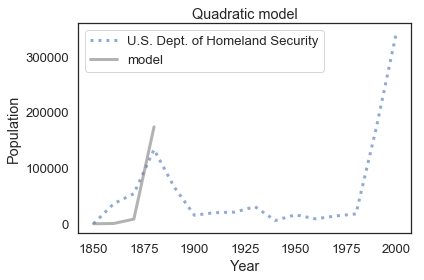

In [42]:
quad_results = run_simulation(system_quad,update_func_quad)
plot_results(immigrant_influx,quad_results,'Quadratic model','U.S. Dept. of Homeland Security')
print(quad_results)

Looking collectively at the three models created, it would seem that the constant model fit best. The reality is, however, that the immigration rate (AKA the slope) is not constant. Instead, it often changes drastically due to a number of factors (i.e. global affairs, desire for one to leave their country, etc). This leaves us with two options: proportional or quadratic model. The quadratic model was eventually chosen because it describes a changing immigration rate as well as one that can both accelerate and taper. 

Now that we have decided on which type of model to use, we can begin extrapolating the number of immigrants that could have arrived during the period the Chinese Exclusion Act and Geary Act were active.

A new `System` object was created to store a different set of inital conditions.

In [43]:
system_extrap = System(t_1880=Year[3],
                      t_1920=Year[7],
                      t_1950=Year[11],
                      t_2000=Year[15],
                      p_1880=pop[3],
                      alpha=1.55,
                      beta=-.00000775)




,values
t_1880,1880.000000
t_1920,1920.000000
t_1950,1960.000000
t_2000,2000.000000
p_1880,133139.000000
alpha,1.550000
beta,-0.000008


A `run_extrapolation` function is created to simulate the number of Chinese immigrants arriving from 1880-2000.

In [44]:
def run_extrapolation(system, update_func):
    """
    Simulate the system using any update function
    
    system: takes a initial System
    update_func: function that computes the population next decade
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_1880] = system.p_1880
    
    for t in linrange(system.t_1880,system.t_2000,10):
        results[t+10] = update_func(results[t], t, system)
        
    return results


A new update function is created to run a quadratic growth model on the number of arriving Chinese immigrants. A few extra conditions were included in attempt to account for the effects on immigration rate from World War 1, World War 2, the Great Depression, and the Cultural Revolution.

In [52]:
def update_func_extrap(pop, t, system):
    """Compute the number of Chinese immigrants arriving in the next decade.
    
    pop: current number of immigrants
    t: current year
    system: system object containing parameters of the model
    
    returns: number of Chinese people immigrating next decade
    """
    #WW1 & WW2
    if t == 1910 or t == 1940: 
        net_growth = -.85 * pop
    #Great Depression
    elif t == 1930:
        net_growth = -.60 * pop
    #Post WW2
    elif t == 1950:
        net_growth = 2 * pop
    #Cultural Revolution
    elif t>1980: 
        net_growth = 1.5 * pop
    #Quadratic Model
    else:
        net_growth = system.alpha * pop + system.beta * pop**2
        
    return pop + net_growth

We ran the simulation and the results were plotted.

1880    133139.000000
1890    202128.001762
1900    198794.503997
1910    200651.760342
1920     30097.764051
1930     69728.763974
1940     27891.505590
1950      4183.725838
1960     12551.177515
1970     30784.629222
1980     71156.180695
1990    142208.444876
2000    355521.112190
dtype: float64
1870.0


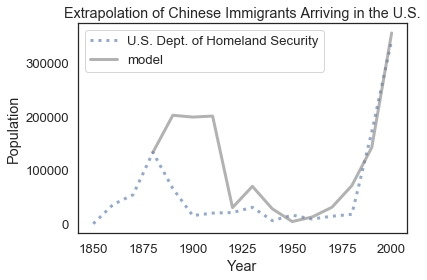

In [46]:
extrap_results = run_extrapolation(system_extrap,update_func_extrap)
plot_results(immigrant_influx,extrap_results,'Extrapolation of Chinese Immigrants Arriving in the U.S.', 'U.S. Dept. of Homeland Security')
print(extrap_results)
print(t)

Now that we have extrapolated values for the number of Chinese immigrants arriving in the U.S., we can then create a population growth model based on the birth/death rate, and the influx of immigrants.

In [54]:
def population_model(system, update_func):
    """
    Simulate the population 
    
    system: takes a initial System
    update_func: function that computes the population next decade
    
    returns: TimeSeries
    """
    results = TimeSeries()
    results[system.t_1880] = china[system.t_1880]

    for t in linrange(system.t_1880, system.t_2000, 10):
        results[t+10] = update_func(results[t], t, system)
    return results
    

A new update function is created to calculate the total increase in number of Chinese-Americans in the U.S every decade. The birth/death rate are combined into a single constant and is estimated to be 2% each decade. This number was determined from the actual increase in the number of Chinese-Americans during 1880-1890 when immigration was banned. Such a low number makes sense historically because most of the Chinese immigrants back then were male.

In [56]:
def update_func_population(pop, t, system):
    """Computes the population of Chinese Americans given extrapolated data and birth/death rate
    
    pop: current number of immigrants
    t: current year
    system: system object containing parameters of the model
        
    returns: population of Chinese Americans next decade
    """

    return (1.02)*pop + extrap_results[t]
    
    

1425655.9002705207

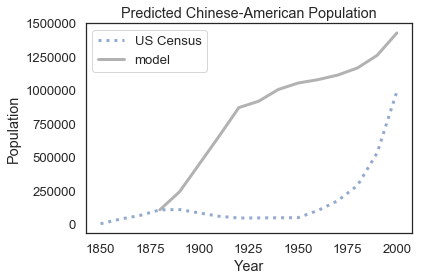

In [49]:
final_results = population_model(system_extrap, update_func_population)
plot_results(china,final_results,'Predicted Chinese-American Population', 'US Census')

final_results[2000]

This figure depicts the predicted Chinese-American population from our model on top of the actual Chinese-American population from the U.S. Census. 

As one can see, the model grows continuously past 1882 as opposed to the data from U.S. Census when the Chinese Exclusion Act was passed. In 1910, the model growth slows down due to the effects of World War 1. It begins to slowly increase again during the Great Depression, but once again drops during World War II. The model does not start to pick up pace until the Cultural Revolution during the 60's, which matches the trend of the data recorded from the U.S. Census.

From this model, we conclude that one possible solution to our question is that the Chinese-American population would have grown up to 1.43 million people had the Chinese Exclusion Act/Geary Act never been implemented. This is 450,000 more people than what the U.S Census records is the actual population in 2000.

Before all is said and done, we must recognize a number of limitations in the making of this model. While we tried accounting for the influence of historical events such as the World Wars and the Great Depression, we cannot verify our conjectures on how severe the impacts of each event would be. Furthermore, we kept the birth/death rate fixed in this model and this is far from reality.

In the future, we could do more research to figure out a better method for calculating birth/death rate. Furthermore, we could do more analysis on how historical events actually affect immigration and make a spread of models to demonstrate different possible outcomes. 
